In [1]:
%pylab inline
import pysd
import pandas as pd
import pyDOE

Populating the interactive namespace from numpy and matplotlib


In [3]:
pysd.tools.static_test_matrix()

parsimonious.grammar.Grammar

# Todo

- What are the conditions under which the test passes.

## Load the model

In [3]:
model = pysd.read_vensim('Goldstone_Tilly_2001_d_08_pysd_simplification.mdl')


True

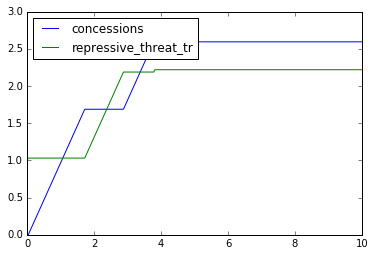

In [4]:
result = model.run(params={'new_advantages_a':6},
          return_columns=['concessions', 'repressive_threat_tr', 'protest'])
result.plot();
plt.legend(loc='upper left')
result['protest'].iloc[-1] == 0

## Define a parameter space 
We'll use a latin hypercube sampling method to sweep over a reasonable range of parameters

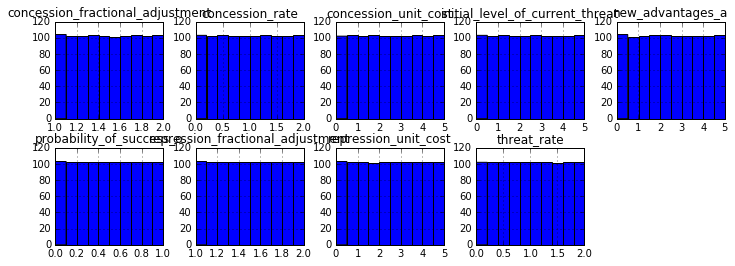

In [7]:
p_ranges = {
    'concession_fractional_adjustment':(1,2),
    'repression_fractional_adjustment':(1,2),
    'initial_level_of_current_threat':(0,5),
    'new_advantages_a':(0,5),
    'threat_rate':(0,2),
    'concession_rate':(0,2),
    'probability_of_success_o':(0,1),
    'repression_unit_cost':(0,5),
    'concession_unit_cost':(0,5)
}
norm_samples = pyDOE.lhs(n=len(p_ranges), samples=1024)

parameters = pd.DataFrame([{key:n*(p[1]-p[0])+p[0] for n,(key,p) in zip(row, p_ranges.iteritems())} 
                           for row in norm_samples])
parameters.hist(figsize=(12,4), layout=(2,5));

<a list of 19 text.Text objects>

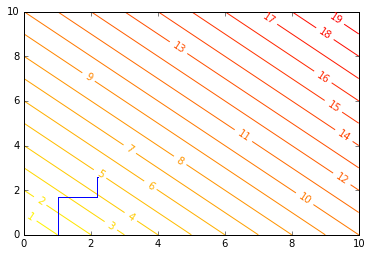

In [8]:
def test(row):
    try:
        output = model.run(row.to_dict().update({'repression_unit_cost':1,'concession_unit_cost':1}), 
                           return_columns=['concessions', 'repressive_threat_tr', 'protest'])
        plt.plot(output['repressive_threat_tr'],output['concessions'],'b', alpha=.55)
    except:
        pass

result = parameters.iloc[:100].apply(test, axis=1)
plt.xlim(0,10)
plt.ylim(0,10)

# constant cost lines
xs, ys = np.meshgrid(np.linspace(0,10,100), np.linspace(0,10,100))
zs = xs + ys
CS = plt.contour(xs,  ys, zs, levels=np.arange(0,20,1), cmap='autumn_r')   
plt.clabel(CS, inline=1, fontsize=10, fmt='%i')

In [178]:
def successmap(result):
    shape = [sqrt(len(result))]*2
    plt.matshow(result.reshape(shape), cmap='bone')
    plt.yticks(np.arange(-.5,shape[0]-.5,1), ())
    plt.xticks(np.arange(-.5,shape[1]-.5,1), ())
    plt.grid(color='grey',linestyle='-')
    ax = plt.gca()
    ax.tick_params(width=0)
    plt.xlim(-.5,shape[0]-.5)
    plt.ylim(-.5,shape[0]-.5)
    plt.plot([-5],[5], 'sk', label='Failure')
    plt.plot([-5],[5], 'sw', label='Success')
    plt.legend(loc='upper center', bbox_to_anchor=(.5,0), ncol=2, frameon=False, markerscale=2, numpoints=1);

### Test 1: Regime Success

#### Claim:
> "The state, ... [may] manipulate 
the current threats to the protest group, and the level of repression that 
follows on protest action. Here there is room for effective action by the state..."
>
> pg 185, para 5

#### Interpretation:
At least in some cases, the state can quell protests through the use of concessions and repression.

#### Test:
Sweep over all range of possible parameters for the model ensuring that in at least one case the simulation begins with protest and ends without it.

True
755


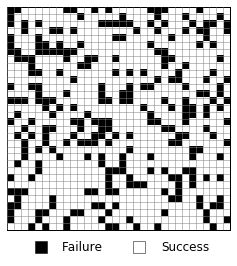

In [183]:
def test(row):
    protest = model.run(row.to_dict(), return_columns=['protest'])['protest']
    return protest.iloc[0] == 1 and protest.iloc[-1] == 0

result = parameters.apply(test, axis=1)
successmap(result)
print any(result)
print sum(result)

### Test 2: Regime Failure 

>"If the regime is bound by the flatter line through point C, as its frontier for action, it has doomed itself; it is now neither capable of enough repression, nor willing to provide enough concessions, to halt the movement.
That is, there is no point on the line through point C that is above the new suppression line A'B'."
>
> pg 189

#### Interpretation:
There is a total cost that the regime is able to pay, above which the regime will fail.

#### Test:
Sweep over the parameter space. In some regions, the cost will exceed the total cost bearable by the regime, regardless of the parameters/actions taken by the regime, and the value for regime survival will drop to zero.

True
14


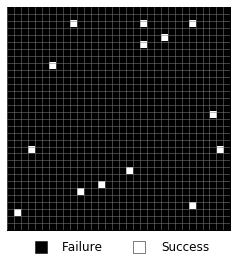

In [184]:
def test(row):
    survival = model.run(row.to_dict(), return_columns=['regime_survival'])['regime_survival']
    return survival.iloc[-1] == 0

result = parameters.apply(test, axis=1)
successmap(result)
print any(result)
print sum(result)

### Test

#### Claim:
> The state may initially set the level of concessions or repression too low, and 
thus find itself under the A\B line. Protest activity will then start to mount, 
and the question for the state is what to do next - increase repression, 
or increase concessions, or both.
>
> [The State] may swing back and forth between concessions and repression, 
trying to find a combination that quells protest, without
success. 
>
> Pg. 188

#### Interpretation
In some cases, the regime may begin by primarily working to increase either repression or concessions, such that the instantaneous rate of **Making concessions** is greater (or less) than that of **Making threats** and then at some point in the simulation, the relative weighting of these two parameters will switch.

#### Test:


True
998


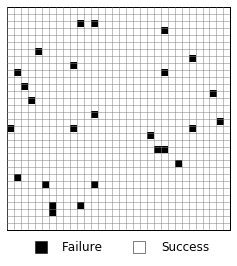

In [182]:
def test(row):
    output = model.run(row.to_dict(), return_columns=['making_concessions','making_threats'])
    # is there a positive preference for making concessions at some point in the simulation
    repr_pref = output['making_concessions'] > output['making_threats']
    # is there a positive preference for making threats at some point in the simulation
    threat_pref = output['making_concessions'] < output['making_threats']
    # do both preferences occur at various points?
    return any(repr_pref) and any(threat_pref)

result = parameters.apply(test, axis=1)
successmap(result)
print any(result)
print sum(result)

### Test 3 A: Moderate Objectives in Liberal, Wealthy Democracies


> "In liberal democratic regimes in wealthy countries, for groups seeking 
modest goals, the costs of repression are likely to be higher than the 
costs of concessions. Thus for most issue-oriented groups, concessions 
and mild repression rather than reverse are the likely pattern of protest..."
>
> "if modest levels of concessions and repression are not sufficient to halt 
the movernent, the system will implement large concessions and preserve 
itself through reforms .."
>
> Pg. 192

#### Interpretation
We expect to see negative correlation between the relative cost of repression to concessions
and the relative use of repression over concessions. 

[[  1.  nan]
 [ nan  nan]]


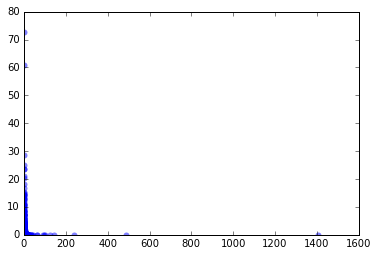

In [33]:
def test(row):
    output = model.run(row.to_dict(), return_columns=['repressive_threat_tr','concessions'])
    return pd.Series({'cost_ratio':row['repression_unit_cost']/row['concession_unit_cost'],
            'use_ratio':output['repressive_threat_tr'].iloc[-1]/output['concessions'].iloc[-1]})

result = parameters.apply(test, axis=1)

result.dropna(inplace=True)
plt.plot(result['cost_ratio'], result['use_ratio'], 'bo', alpha=.5, mew=0)
print np.corrcoef(result['cost_ratio'], result['use_ratio'])

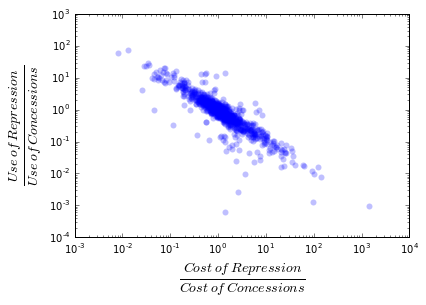

In [60]:
plt.loglog(result['cost_ratio'], result['use_ratio'], 'bo', alpha=.25, mew=0)
#print np.corrcoef(result['cost_ratio'], result['use_ratio'])
plt.ylim(.0001,1000)
plt.xlabel('$\\frac{Cost\:of\:Repression}{Cost\:of\:Concessions}$', fontsize=20)
plt.ylabel('$\\frac{Use\:of\:Repression}{Use\:of\:Concessions}$', fontsize=20)

### Test 3 B: Extreme Objectives in Liberal, Wealthy Democracies
> "In liberal democratic regimes in wealthy countries, ... For groups to whom concessions would he exceptionally costly (for example, socialist groups seeking to overthrow capitalism); in these special cases a 
strong effort at repression and not concessions is the more likely response."
>
> Pg. 192

#### Implication
As the level of demands - or perhaps 

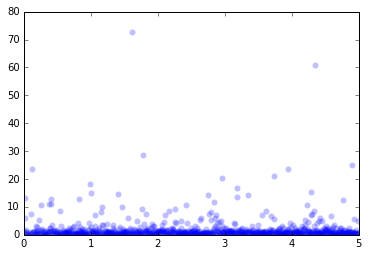

In [61]:
def test(row):
    output = model.run(row.to_dict(), return_columns=['repressive_threat_tr','concessions'])
    return pd.Series({'demands':row['new_advantages_a'],
                      'use_ratio':output['repressive_threat_tr'].iloc[-1]/output['concessions'].iloc[-1]})

result = parameters.apply(test, axis=1)

result.dropna(inplace=True)
plt.plot(result['demands'], result['use_ratio'], 'bo', alpha=.25, mew=0)
#print np.corrcoef(result['cost_ratio'], result['use_ratio'])

### Test

#### Claim:
> Authoritarian states may thus if they overestimate their support and 
underestimate that of the opposition, rachet up repression slowly and insufficiently 
to halt mobilization, while refusing to make concessions that would relieve the current 
threat imposed by existing conditions.
>
> Pg. 188

#### Interpretation
Slow implementation of repression may fail to stop protests that would have been successfully repressed through rapid application of the same absolute level of repression.

### Test

#### Claim
> [The State] may swing back and forth between concessions and repression, 
trying to find a combination that quells protest. 
> This kind of inconsistent repression and concession is strongly
associated with increasing protest actions.
>
> Pg. 188

#### Interpretation
In some cases, the regime may begin by primarily working to increase either repression or concessions, and then at some point in the simulation switch to the other strategy

### Test

#### Claim:
> "the effect of state actions in response to protest may be to shift the suppression line
AB outward to A'B'"
>
> Pg. 189

#### Interpretation:
At least in some cases, an increase in 

### Test


> In some cases, where authorities respond to protests with repression, 
the result is distress and anger among the population which creates more 
opposition supporters, increases the perceived threat of the status quo, 
and thus leads people to be willing to bear greater costs to overturn the 
regime. The repression thus acts to move the A\B line outward, and it may 
initially move further and faster than the regime's repression can keep 
pace with. 
>
> Pg. 190


### Test 

> In many cases, the regime was never able to get back "on the other side"
of the advancing A\B boundary. This might be because after some initial rounds 
of inadequate repression or concessions, the newly required level of repression 
was too costly, or the regime was constrained by internal or external factors, 
or it exceeded the capacity of the regime to implement.
> 
> Pg. 190

Limitations come not from costs, but from capacities

### Test

> "Repressive actions against protest did more to discredit regimes than to suppress
mobilization...
> As the costs of repression and the constraints of external opinion limited repressive
strategies, while mobilization and protest continued, the regimes adopted massive
concessions to avert revolutionary conflict.
>
> Pg. 192

### Test

> "In this case, the regime largely (although not entirely) refrains from violent 
repression, preferring to offer concessions. In some cases, the concessions may be 
insufficient, leading to more and more protests until massive reforms occur."
>
> Pg. 192

### Test

> "For authoritarian regimes, concessions to any groups challenging their monopoly 
of power is likely to be more costly than repression; thus repression is more 
likely to dominate protest in these settings."
>
> "However, repression has its costs as well, particularly if it alienates aid donors
and trading partners. Such regimes are therefore likely to Swing between token 
concessions and repression, as their estimates of the costs of each fluctuates"
>
> Pg. 192
